In [1]:
## 자산 및 전략를 적립식으로 투자했을 때 투자 성과를 시뮬레이션할 수 있습니다.

In [1]:
# 기본 패키지
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [6]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf

In [7]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## Function

In [8]:
def investment_simulation(price_series, monthly_investment, years):
    """
    특정 자산 가격의 월간 시계열 데이터와 일정한 월 투자 금액을 기반으로
    투자 시작 시점별로 n년 동안의 투자 경과를 시뮬레이션하는 함수.

    Parameters:
        price_series (pd.Series): 월 단위 자산 가격 시계열 데이터 (Index: 날짜)
        monthly_investment (float): 매월 투자하는 금액
        years (int): 투자 기간 (년)

    Returns:
        List[pd.DataFrame]: 각 투자 시작 시점별 매월 투자 결과를 포함한 데이터프레임 리스트
    """
    results = []  # 투자 시뮬레이션 결과를 저장할 리스트
    months = years * 12  # 투자 기간을 월 단위로 변환
    
    for start_idx in range(len(price_series) - months):
        end_idx = start_idx + months  # 투자 종료 월
        
        # 투자 기간 내의 가격 데이터 가져오기
        invest_prices = price_series.iloc[start_idx:end_idx+1]
        
        total_invested = 0  # 총 투자 금액
        total_units = 0  # 총 매수한 자산 개수
        records = []  # 매월 기록 저장
        
        for i in range(len(invest_prices)):
            date = invest_prices.index[i]  # 현재 투자 월
            price = invest_prices.iloc[i]  # 해당 월의 가격
            
            # 매월 투자
            total_invested += monthly_investment
            total_units += monthly_investment / price  # 해당 월의 가격으로 매수
            
            # 현재 평가 금액 계산
            final_value = total_units * price
            
            # 기록 저장
            records.append({
                "Date": date,
                "Total_Invested": total_invested,
                "Total_Units": total_units,
                "Final_Value": final_value
            })
        
        # 데이터프레임 변환 후 리스트에 저장
        results.append(pd.DataFrame(records).set_index("Date"))
    scores = pd.DataFrame([(_df.index[0], (_df['Final_Value'][-1]/_df['Total_Invested'][-1]-1)*100) for _df in results], columns=['Date', 'Total_Return']).set_index('Date')
    return results, scores

## DataLoad

In [9]:
dataset = pd.read_csv('trend_data.csv', index_col=0)
dataset.index = pd.to_datetime(dataset.index)

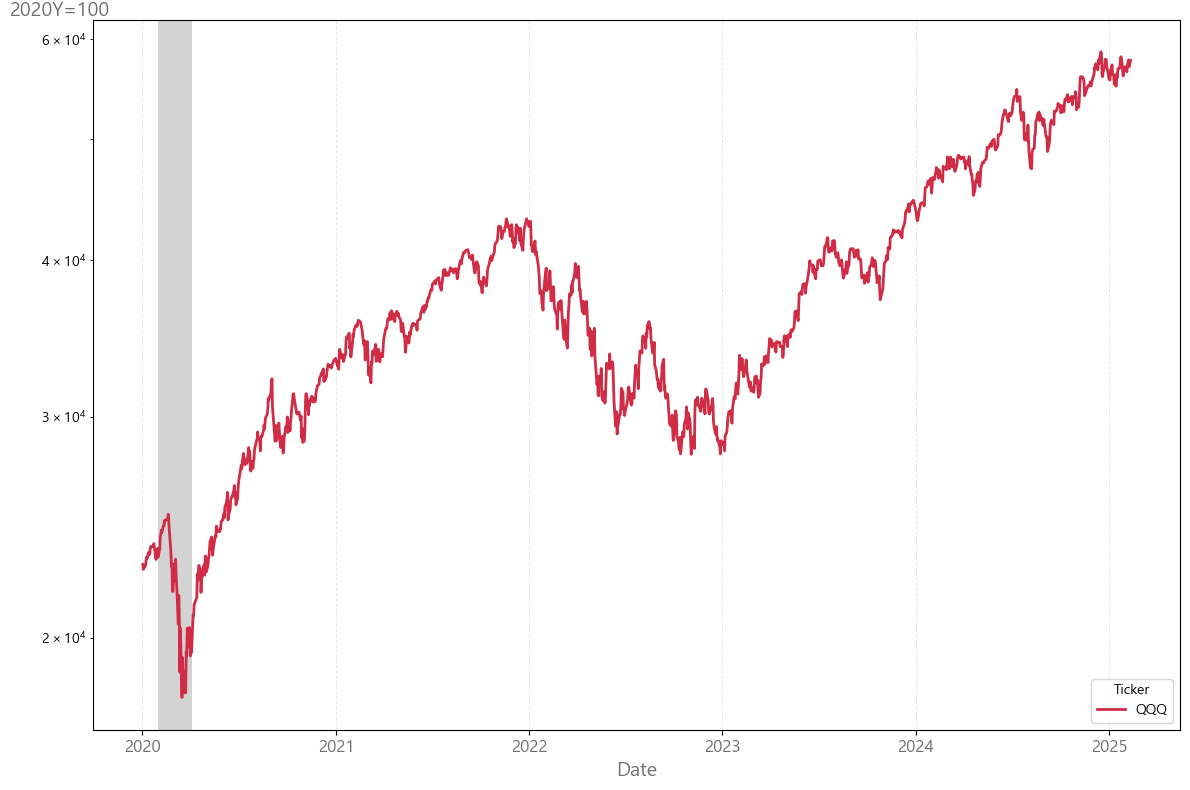

In [14]:
gm.trend_plot(dataset["2020":], ['QQQ'], title=False, yscale='log', colors=[mycolors['color_norm']])

## Simulation

In [40]:
year = len(dataset['QQQ']['2000':].resample('M').first())//12
month = year*12
simulations, scores = investment_simulation(dataset['QQQ']['2000':].resample('M').first(), 100*1e4, year)

min_index = scores[scores['Total_Return'] == scores['Total_Return'].min()].index[0]
min_index = scores.index.get_loc(min_index)

max_index = scores[scores['Total_Return'] == scores['Total_Return'].max()].index[0]
max_index = scores.index.get_loc(max_index)

worst_case = simulations[min_index][['Total_Invested', 'Final_Value']].head(month)
best_case = simulations[max_index][['Total_Invested', 'Final_Value']].head(month)

In [41]:
worst_case['return_rate'] = (worst_case['Final_Value']/worst_case['Total_Invested'] - 1)*100

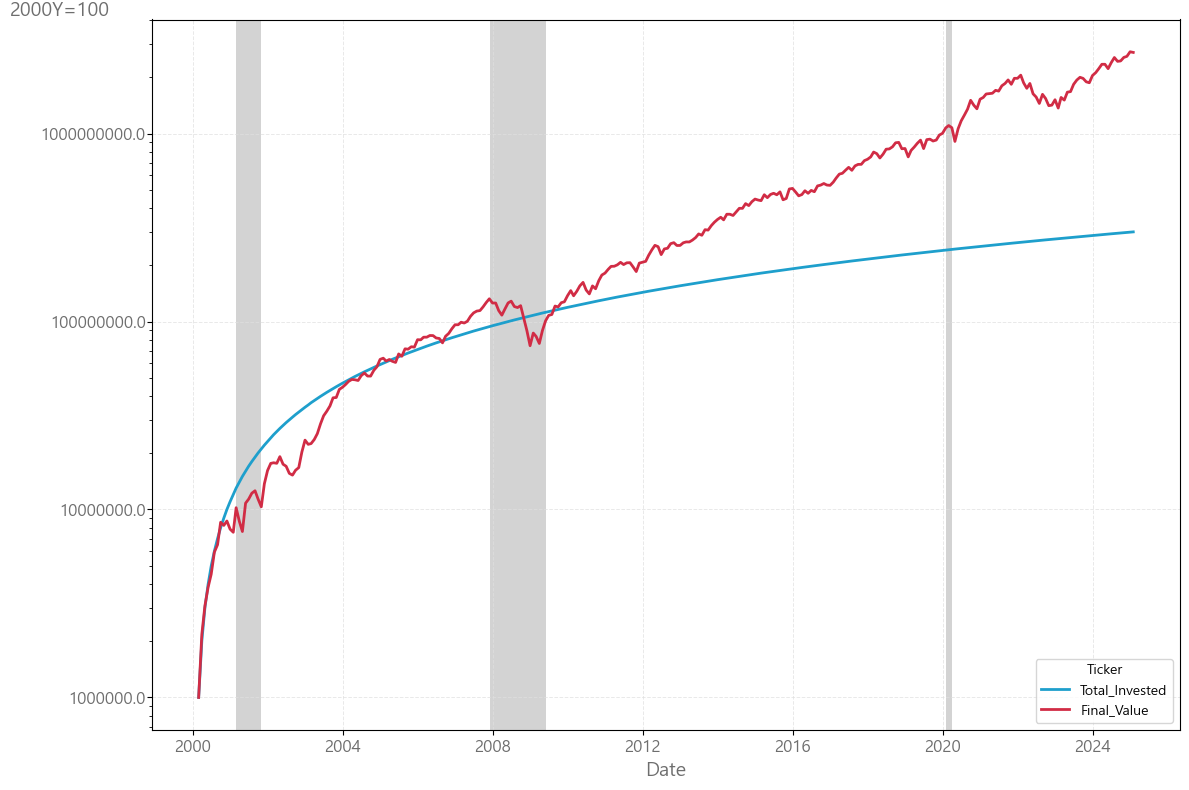

In [42]:
## worst_case.plot()
gm.trend_plot(best_case, ['Total_Invested', 'Final_Value'], title=False, yscale='log', colors=[mycolors['color_cont'], mycolors['color_norm']])

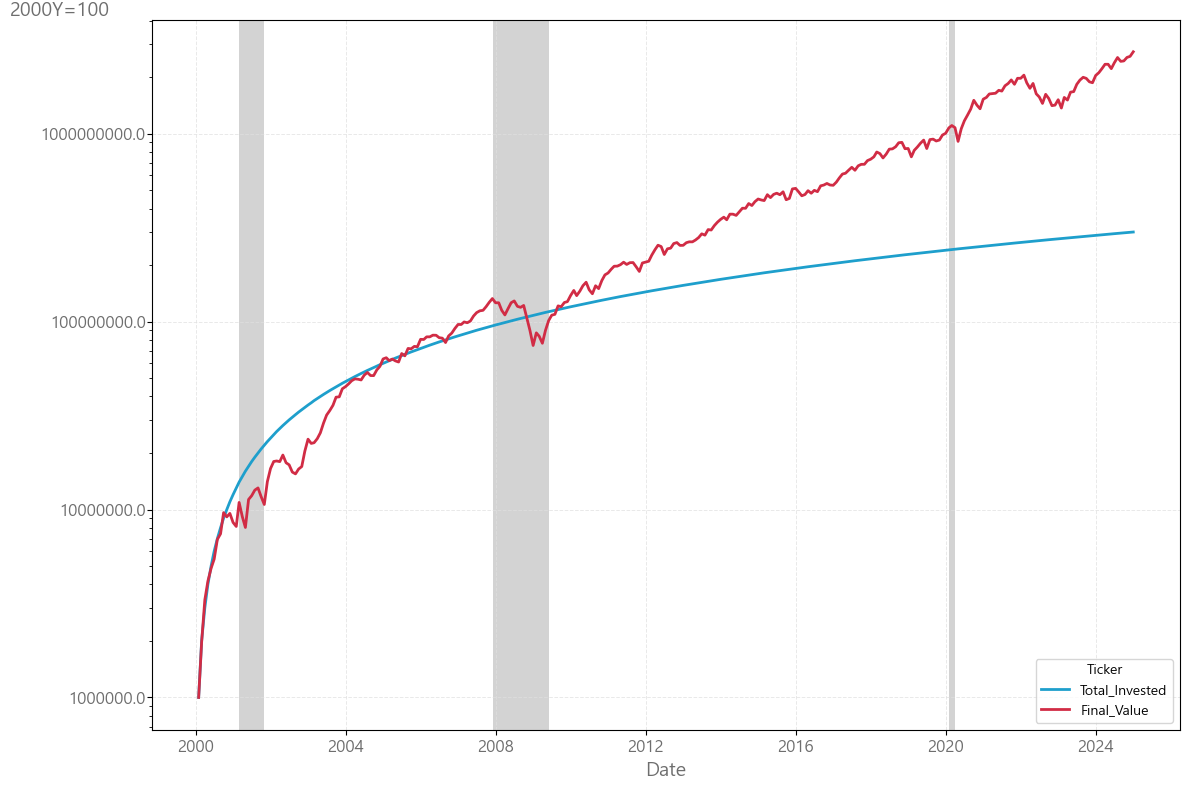

In [43]:
## worst_case.plot()
gm.trend_plot(worst_case, ['Total_Invested', 'Final_Value'], title=False, yscale='log', colors=[mycolors['color_cont'], mycolors['color_norm']])

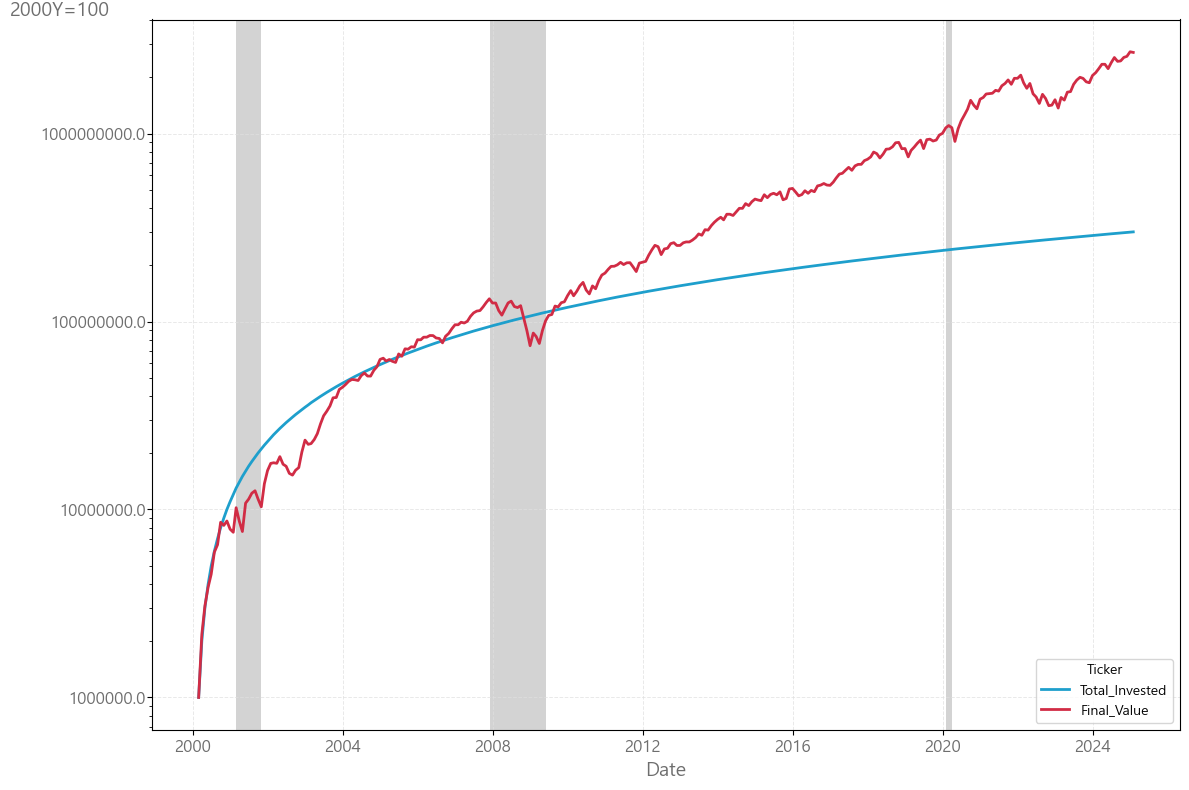

In [46]:
## worst_case.plot()
gm.trend_plot(simulations[-1].head(300), ['Total_Invested', 'Final_Value'], title=False, yscale='log', colors=[mycolors['color_cont'], mycolors['color_norm']])

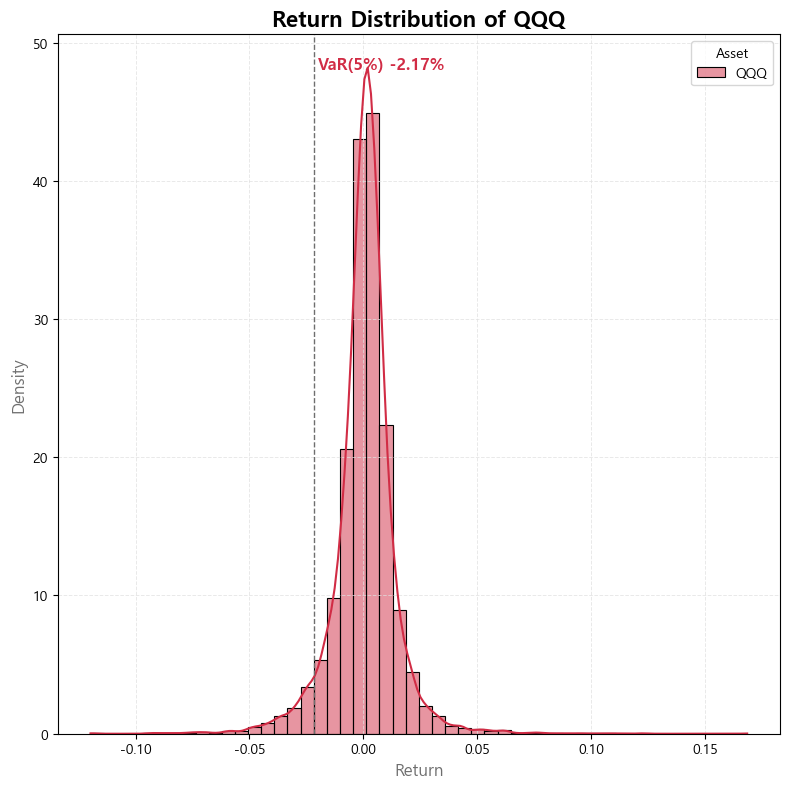

In [21]:
gm.asset_histogram_plot(dataset.pct_change(), ['QQQ'], colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']], var_value=5)